In [18]:
import gensim.downloader as api
from sklearn.decomposition import PCA
# Load Word2Vec model trained on Google News dataset
print("Loading Word2Vec model...")
word2vec_model = api.load('word2vec-google-news-300')

# Define a function to get the vector representation of a document
def document_vector(doc):
    # Remove punctuation and tokenize the document
    tokens = [word.lower() for word in word_tokenize(doc) if word.lower() not in punctuation_set]
    # Filter out tokens that are not in the Word2Vec model's vocabulary
    tokens = [word for word in tokens if word in word2vec_model.key_to_index]
    if len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Calculate the mean of word vectors for tokens in the document
    return np.mean(word2vec_model[tokens], axis=0)

# Obtain Word2Vec embeddings for each document
print("Obtaining Word2Vec embeddings for each document...")
word2vec_embeddings = np.array([document_vector(doc) for doc in processed_data])

# Use GWO-Kmeans with Word2Vec embeddings
n_clusters = 2
kmeans = gwo_kmeans(word2vec_embeddings, n_clusters)

# Evaluate clustering performance
silhouette = silhouette_score(word2vec_embeddings, kmeans.labels_)
davies_bouldin = davies_bouldin_score(word2vec_embeddings, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(word2vec_embeddings, kmeans.labels_)

print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Loading Word2Vec model...
Obtaining Word2Vec embeddings for each document...
Cluster centers: [[ 8.07952881e-03  2.50061035e-01  3.41796875e-03  3.10058594e-01
  -2.64953613e-01  1.39038086e-01  1.19018555e-01  1.25488281e-01
   1.07299805e-01 -2.90374756e-02 -7.50122070e-02 -2.45849609e-01
  -9.02099609e-02 -1.38427734e-01 -9.38110352e-02  1.82861328e-01
   6.15234375e-02  8.25805664e-02 -2.50976562e-01 -1.94824219e-01
   1.69082642e-01  1.64062500e-01  2.18750000e-01  1.32141113e-02
  -9.64355469e-02  7.40966797e-02 -1.67602539e-01  5.41992188e-02
   1.80053711e-01  1.67236328e-01 -7.81860352e-02 -1.71142578e-01
  -1.33911133e-01 -6.12792969e-02 -8.93554688e-02  3.13720703e-02
   1.74560547e-01 -2.19726563e-02  5.57632446e-02  1.31347656e-01
   1.20361328e-01  1.16699219e-01  4.23828125e-01  4.87442017e-02
  -1.42944336e-01 -4.54101562e-02 -2.49572754e-01 -1.63269043e-01
  -1.14379883e-01  1.45275116e-01 -1.00341797e-01  3.69110107e-02
  -1.47247314e-01  4.45861816e-02  3.43261719e-0

In [8]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [9]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia

In [10]:
class GreyWolf:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.score = float('inf')

In [11]:
def gwo_kmeans(data, n_clusters, n_wolves=10, max_iter=100):
    wolves = [GreyWolf(data, n_clusters) for _ in range(n_wolves)]

    alpha, beta, delta = None, None, None

    for _ in range(max_iter):
        # Calculate fitness for each wolf
        for wolf in wolves:
            wolf.score = compute_inertia(wolf.position, data)
            if alpha is None or wolf.score < alpha.score:
                alpha, beta, delta = wolf, alpha, beta
            elif beta is None or wolf.score < beta.score:
                beta, delta = wolf, beta
            elif delta is None or wolf.score < delta.score:
                delta = wolf

        # Update positions
        a = 2 - 2 * _ / max_iter  # Decrease linearly from 2 to 0
        for wolf in wolves:
            for i in range(n_clusters):
                wolf.position[i] = (alpha.position[i] - a * abs(alpha.position[i] - wolf.position[i]) +
                                    beta.position[i] - a * abs(beta.position[i] - wolf.position[i]) +
                                    delta.position[i] - a * abs(delta.position[i] - wolf.position[i])) / 3

    final_kmeans = KMeans(n_clusters=n_clusters, init=np.array(alpha.position), n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans

In [12]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [14]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [16]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]

In [20]:
n_clusters = 2
kmeans = gwo_kmeans(word2vec_embeddings, n_clusters)
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
#GWO-Kmeans on 20newsgroups


Cluster centers: [[-3.06950568e-03  2.67031853e-02  4.14926410e-04  9.72444515e-02
  -5.59194742e-02  1.92432839e-02  2.99569795e-02 -5.76813206e-02
   5.71515042e-02  5.76908251e-02 -6.25628665e-02 -1.08392618e-01
  -7.55516570e-02 -2.51592562e-03 -7.05239410e-02  9.24515930e-02
   5.17044323e-02  1.03304387e-01 -1.14098221e-03 -8.74789730e-02
  -2.13814923e-02  1.53064983e-02  5.49667070e-02  7.44788082e-03
  -1.26372059e-02 -6.84372408e-03 -1.10184810e-01  9.32716651e-02
   3.39257606e-02 -4.17962725e-02 -2.87571665e-02  1.61476138e-02
  -4.34492790e-02 -5.15234004e-02 -5.77681731e-02 -1.95019464e-02
   1.16683519e-02  4.31662278e-02  5.28209770e-02  3.50940209e-02
   5.30619048e-02 -1.64392616e-02  1.33475263e-01  2.64622535e-02
  -5.18051839e-03 -6.13579236e-02 -2.65832586e-02 -3.66121471e-02
  -5.61373228e-02  3.34804679e-02 -7.07977742e-02  3.07498244e-02
   2.55467601e-02 -4.80327071e-03 -1.31554656e-02  2.49112363e-02
  -5.28466961e-02 -6.34478215e-02  1.48267388e-02 -6.458207

In [21]:
silhouette = silhouette_score(word2vec_embeddings, kmeans.labels_)
davies_bouldin = davies_bouldin_score(word2vec_embeddings, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(word2vec_embeddings, kmeans.labels_)

print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Cluster centers: [[-3.06950568e-03  2.67031853e-02  4.14926410e-04  9.72444515e-02
  -5.59194742e-02  1.92432839e-02  2.99569795e-02 -5.76813206e-02
   5.71515042e-02  5.76908251e-02 -6.25628665e-02 -1.08392618e-01
  -7.55516570e-02 -2.51592562e-03 -7.05239410e-02  9.24515930e-02
   5.17044323e-02  1.03304387e-01 -1.14098221e-03 -8.74789730e-02
  -2.13814923e-02  1.53064983e-02  5.49667070e-02  7.44788082e-03
  -1.26372059e-02 -6.84372408e-03 -1.10184810e-01  9.32716651e-02
   3.39257606e-02 -4.17962725e-02 -2.87571665e-02  1.61476138e-02
  -4.34492790e-02 -5.15234004e-02 -5.77681731e-02 -1.95019464e-02
   1.16683519e-02  4.31662278e-02  5.28209770e-02  3.50940209e-02
   5.30619048e-02 -1.64392616e-02  1.33475263e-01  2.64622535e-02
  -5.18051839e-03 -6.13579236e-02 -2.65832586e-02 -3.66121471e-02
  -5.61373228e-02  3.34804679e-02 -7.07977742e-02  3.07498244e-02
   2.55467601e-02 -4.80327071e-03 -1.31554656e-02  2.49112363e-02
  -5.28466961e-02 -6.34478215e-02  1.48267388e-02 -6.458207

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
Labels_save=[];
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans =  gwo_kmeans(word2vec_embeddings, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(word2vec_embeddings, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(word2vec_embeddings, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(word2vec_embeddings, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_14868\587791035.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_14868\587791035.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


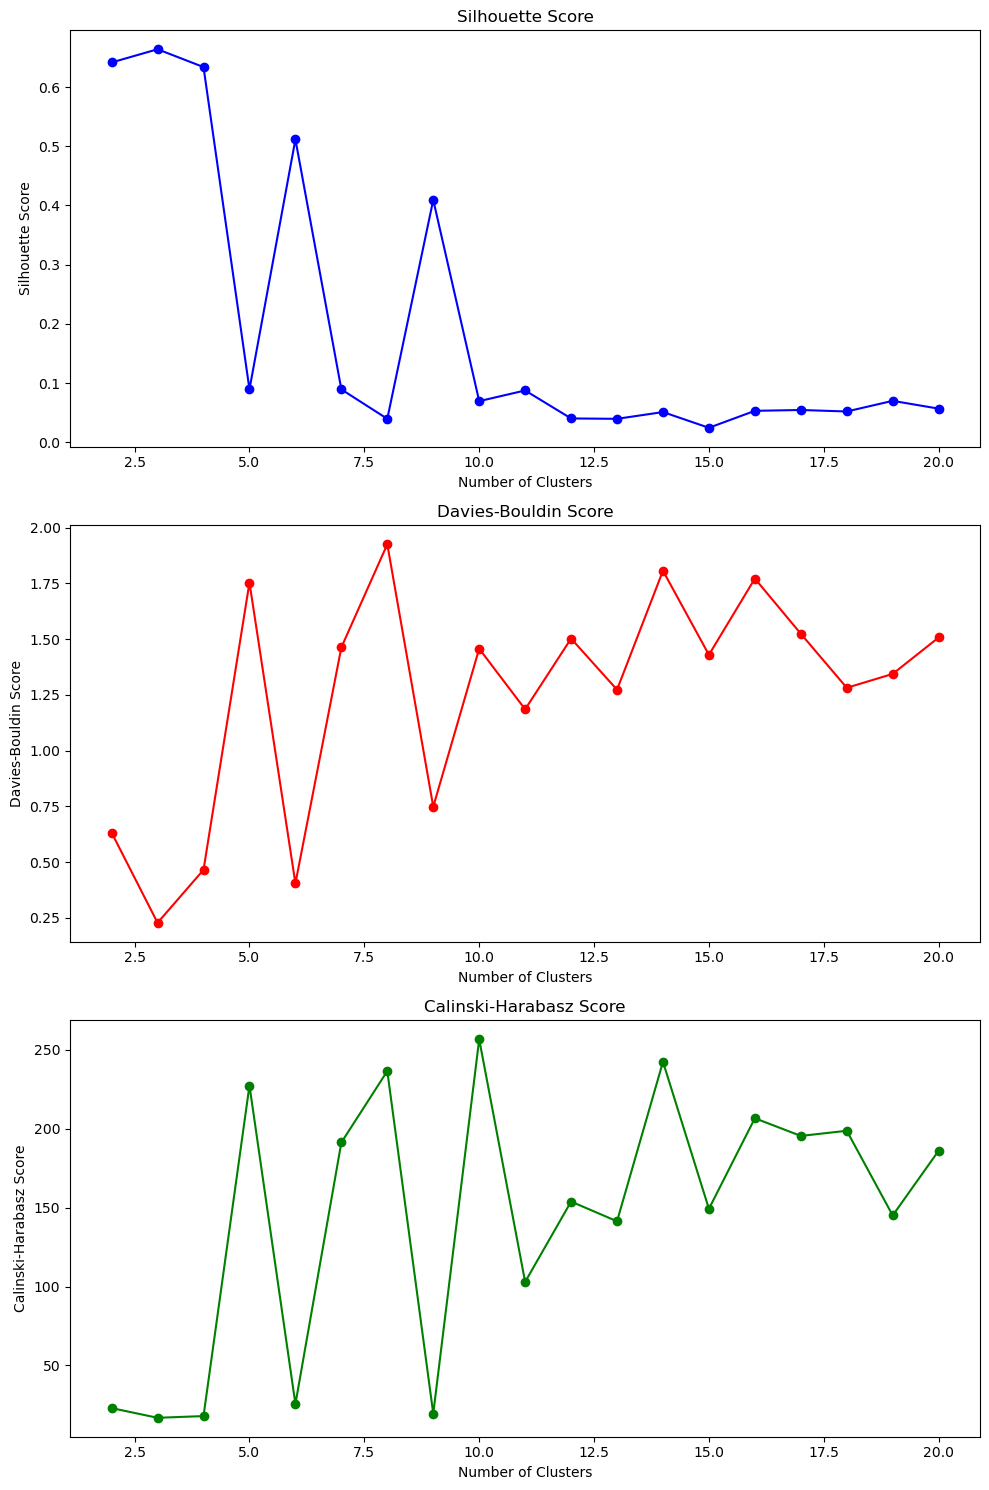

In [25]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_count-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_count-Kmeans.png")
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))

In [27]:
df.to_csv('News_word2vec_GWO-Kmeans.csv')

In [ ]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(tfidf_matrix_reduced)

# Visualizing the clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
plt.title(f'PCA of KMeans Clusters ({n_clusters} Clusters)')
plt.show()